In [145]:
import torch
from torch import nn, optim
from torch.nn import functional as F
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [82]:
# Load the training datasets
train_imgs_path = 'k49-train-imgs.npz'
train_labels_path = 'k49-train-labels.npz'

train_imgs_data = np.load(train_imgs_path)
train_labels_data = np.load(train_labels_path)

train_images = train_imgs_data['arr_0']
train_labels = train_labels_data['arr_0']

# Load the testing datasets
test_imgs_path = 'k49-test-imgs.npz'
test_labels_path = 'k49-test-labels.npz'

test_imgs_data = np.load(test_imgs_path)
test_labels_data = np.load(test_labels_path)

test_images = test_imgs_data['arr_0']
test_labels = test_labels_data['arr_0']

In [83]:
# Threshold value for distinguishing foreground
threshold = 0

# Calculate number of foreground pixels for each image in the training set
train_foreground_pixel_counts = np.sum(train_images > threshold, axis=(1, 2))

# Calculate number of foreground pixels for each image in the testing set
test_foreground_pixel_counts = np.sum(test_images > threshold, axis=(1, 2))

In [84]:
class_pixel_counts = {i: [] for i in range(49)}

for label, pixel_count in zip(train_labels, train_foreground_pixel_counts):
    class_pixel_counts[label].append(pixel_count)

# Calculate median for each class
class_medians = {cls: np.median(counts) for cls, counts in class_pixel_counts.items()}

In [85]:
train_style_labels = []

for label, pixel_count in zip(train_labels, train_foreground_pixel_counts):
    if pixel_count > class_medians[label]:
        train_style_labels.append(1)  # 'thick'
    else:
        train_style_labels.append(0)  # 'thin'

train_style_labels = np.array(train_style_labels)

test_style_labels = []

for label, pixel_count in zip(test_labels, test_foreground_pixel_counts):
    if pixel_count > class_medians[label]:
        test_style_labels.append(1)  # 'thick'
    else:
        test_style_labels.append(0)  # 'thin'

test_style_labels = np.array(test_style_labels)

In [86]:
# Save training labels with style
np.savez('k49-train-labels-with-style.npz', labels=train_labels, style_labels=train_style_labels)

# Save testing labels with style
np.savez('k49-test-labels-with-style.npz', labels=test_labels, style_labels=test_style_labels)

In [146]:
train_imgs_path = 'k49-train-imgs.npz'
train_labels_path = 'k49-train-labels-with-style.npz'

train_images = np.load(train_imgs_path)['arr_0']
train_data = np.load(train_labels_path)
train_labels = train_data['labels']
train_style_labels = train_data['style_labels']

test_imgs_path = 'k49-test-imgs.npz'
test_labels_path = 'k49-test-labels-with-style.npz'

test_images = np.load(test_imgs_path)['arr_0']
test_data = np.load(test_labels_path)
test_labels = test_data['labels']
test_style_labels = test_data['style_labels']

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Flatten images and convert to PyTorch tensors
train_images = torch.tensor(train_images, dtype=torch.float32).view(-1, 784)
test_images = torch.tensor(test_images, dtype=torch.float32).view(-1, 784)

# One-hot encode labels and styles
num_classes = 49
num_styles = 2

train_labels = train_labels.astype(int)
train_style_labels = train_style_labels.astype(int)

train_labels_one_hot = torch.eye(num_classes)[train_labels]
train_style_labels_one_hot = torch.eye(num_styles)[train_style_labels]

test_labels = test_labels.astype(int)
test_style_labels = test_style_labels.astype(int)

test_labels_one_hot = torch.eye(num_classes)[test_labels]
test_style_labels_one_hot = torch.eye(num_styles)[test_style_labels]

# Create DataLoader for training and testing
train_dataset = TensorDataset(train_images, train_labels_one_hot, train_style_labels_one_hot)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

test_dataset = TensorDataset(test_images, test_labels_one_hot, test_style_labels_one_hot)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# => Conditional Variational Autoencoder (C-VAE)

In [159]:
class CVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes, num_styles):
        super(CVAE, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.num_styles = num_styles

        # Encoder
        self.fc1 = nn.Linear(input_dim + num_classes + num_styles, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim + num_classes + num_styles, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x, c, s):
        x = torch.cat((x, c, s), dim=1)
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c, s):
        z = torch.cat((z, c, s), dim=1)
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x, c, s):
        mu, logvar = self.encode(x.view(-1, self.input_dim), c, s)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c, s), mu, logvar
    
def cvae_loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [160]:
# Model parameters
input_size = 784
latent_dim = 2
hidden_sqrt = 12
hidden_size = hidden_sqrt * hidden_sqrt
num_epochs = 40
learning_rate = 0.001

cvae = CVAE(input_size, hidden_size, latent_dim, num_classes, num_styles)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

In [21]:
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    cvae.train()
    train_loss = 0
    for data, label, style in train_loader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data, label, style)
        loss = cvae_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')

torch.save(cvae.state_dict(), 'cvae.pth')

end_time = time.time()

training_duration = end_time - start_time
training_duration_minutes = training_duration / 60
print(f"Training completed in: {training_duration_minutes:.2f} minutes")

Epoch 1, Loss: 268.4778
Epoch 2, Loss: 248.3789
Epoch 3, Loss: 243.5916
Epoch 4, Loss: 240.6472
Epoch 5, Loss: 238.6640
Epoch 6, Loss: 237.2555
Epoch 7, Loss: 236.1907
Epoch 8, Loss: 235.3184
Epoch 9, Loss: 234.6131
Epoch 10, Loss: 233.9962
Epoch 11, Loss: 233.5057
Epoch 12, Loss: 233.0554
Epoch 13, Loss: 232.6509
Epoch 14, Loss: 232.3089
Epoch 15, Loss: 232.0026
Epoch 16, Loss: 231.7090
Epoch 17, Loss: 231.4480
Epoch 18, Loss: 231.2215
Epoch 19, Loss: 231.0058
Epoch 20, Loss: 230.7995
Epoch 21, Loss: 230.6172
Epoch 22, Loss: 230.4437
Epoch 23, Loss: 230.2677
Epoch 24, Loss: 230.1181
Epoch 25, Loss: 229.9604
Epoch 26, Loss: 229.8415
Epoch 27, Loss: 229.6812
Epoch 28, Loss: 229.5661
Epoch 29, Loss: 229.4465
Epoch 30, Loss: 229.3303
Epoch 31, Loss: 229.2455
Epoch 32, Loss: 229.1259
Epoch 33, Loss: 229.0316
Epoch 34, Loss: 228.9391
Epoch 35, Loss: 228.8543
Epoch 36, Loss: 228.7627
Epoch 37, Loss: 228.6775
Epoch 38, Loss: 228.5982
Epoch 39, Loss: 228.5222
Epoch 40, Loss: 228.4494
Training 

In [161]:
cvae = CVAE(input_size, hidden_size, latent_dim, num_classes, num_styles)
cvae.load_state_dict(torch.load('cvae.pth'))
cvae.eval()
test_loss = 0
with torch.no_grad():
    for data, label, style in test_loader:
        recon_batch, mu, logvar = cvae(data, label, style)
        loss = cvae_loss_function(recon_batch, data, mu, logvar)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader.dataset)
print(f'Test Loss: {avg_test_loss:.4f}')

Test Loss: 239.9837


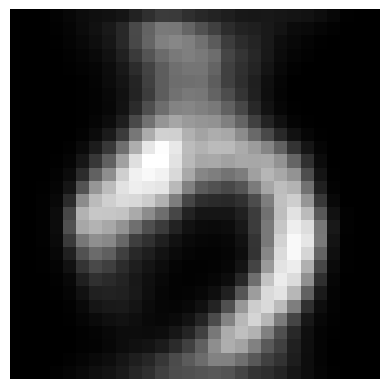

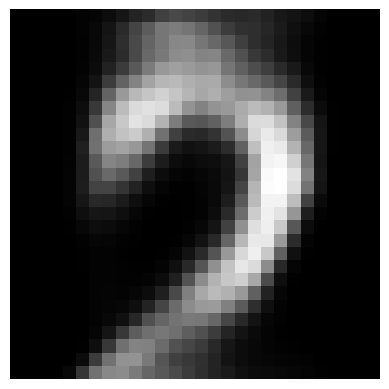

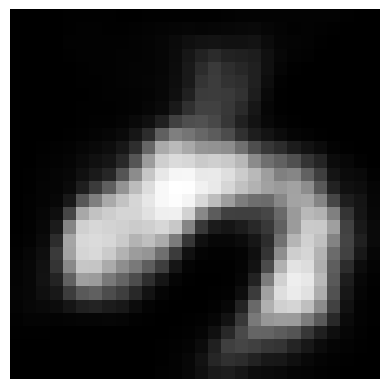

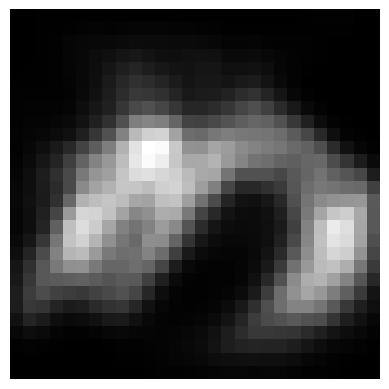

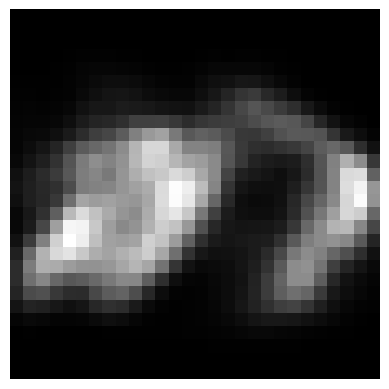

In [162]:
def generate_images(model, class_label, style_label, num_images=5):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim)
        c = torch.eye(num_classes)[torch.tensor([class_label] * num_images)]
        s = torch.eye(num_styles)[torch.tensor([style_label] * num_images)]
        generated_images = model.decode(z, c, s)
        for i in range(num_images):
            plt.imshow(generated_images[i].view(28, 28), cmap='gray')
            plt.axis('off')
            plt.show()

generate_images(cvae, class_label=5, style_label=0, num_images=5)

# => Conditional Generative Adversarial Network (C-GAN)

In [163]:
device = 'cpu'

class Generator(nn.Module):
    def __init__(self, latent_dim, label_dim, style_dim, img_dim):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(latent_dim + label_dim + style_dim, 256),
            nn.ReLU(),
            nn.Linear(256, img_dim),
            nn.Tanh(),
        )

    def forward(self, noise, labels, styles):
        input = torch.cat((noise, labels, styles), dim=1)
        return self.gen(input)


class Discriminator(nn.Module):
    def __init__(self, img_dim, label_dim, style_dim):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim + label_dim + style_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, labels, styles):
        input = torch.cat((img, labels, styles), dim=1)
        return self.disc(input)

In [164]:
# Hyperparameters
latent_dim = 128
img_dim = 784  # 28x28 flattened
label_dim = num_classes
style_dim = num_styles
batch_size = 64
lr = 0.0001
epochs = 40  

# Initialize models
generator = Generator(latent_dim, label_dim, style_dim, img_dim).to(device)
discriminator = Discriminator(img_dim, label_dim, style_dim).to(device)

# Optimizers
opt_gen = optim.Adam(generator.parameters(), lr=lr)
opt_disc = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()

save_generator = 'generator.pth'

In [38]:
start_time = time.time()

# Training loop
for epoch in range(epochs):
    for batch_idx, (real, labels, styles) in enumerate(train_loader):
        real = real.to(device)
        labels = labels.to(device)
        styles = styles.to(device)
        batch_size = real.size(0)

        # Generate fake images
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake = generator(noise, labels, styles)

        # Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = discriminator(real, labels, styles).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = discriminator(fake.detach(), labels, styles).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        discriminator.zero_grad()
        lossD.backward()
        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z)))
        output = discriminator(fake, labels, styles).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        generator.zero_grad()
        lossG.backward()
        opt_gen.step()

        # Print progress
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(train_loader)} Loss D: {lossD:.4f}, Loss G: {lossG:.4f}")

    torch.save(generator.state_dict(), save_generator)
    print(f"Saved generator state dict to {save_generator} after epoch {epoch + 1}")
    
end_time = time.time()

training_duration = end_time - start_time
training_duration_minutes = training_duration / 60
print(f"Training completed in: {training_duration_minutes:.2f} minutes")

Epoch [0/40] Batch 0/2324 Loss D: 0.6857, Loss G: 0.6943
Epoch [0/40] Batch 100/2324 Loss D: 0.7644, Loss G: 0.6434
Epoch [0/40] Batch 200/2324 Loss D: 0.5244, Loss G: 0.9300
Epoch [0/40] Batch 300/2324 Loss D: 0.4958, Loss G: 1.2402
Epoch [0/40] Batch 400/2324 Loss D: 0.6001, Loss G: 0.9966
Epoch [0/40] Batch 500/2324 Loss D: 0.5586, Loss G: 0.9152
Epoch [0/40] Batch 600/2324 Loss D: 0.4773, Loss G: 1.0519
Epoch [0/40] Batch 700/2324 Loss D: 0.4181, Loss G: 1.0341
Epoch [0/40] Batch 800/2324 Loss D: 0.4267, Loss G: 0.9842
Epoch [0/40] Batch 900/2324 Loss D: 0.5051, Loss G: 0.9240
Epoch [0/40] Batch 1000/2324 Loss D: 0.5522, Loss G: 0.7922
Epoch [0/40] Batch 1100/2324 Loss D: 0.5399, Loss G: 0.8390
Epoch [0/40] Batch 1200/2324 Loss D: 0.4885, Loss G: 0.9777
Epoch [0/40] Batch 1300/2324 Loss D: 0.4065, Loss G: 1.2188
Epoch [0/40] Batch 1400/2324 Loss D: 0.3885, Loss G: 1.2195
Epoch [0/40] Batch 1500/2324 Loss D: 0.3270, Loss G: 1.3074
Epoch [0/40] Batch 1600/2324 Loss D: 0.3921, Loss G:

Epoch [5/40] Batch 1300/2324 Loss D: 0.2228, Loss G: 2.1325
Epoch [5/40] Batch 1400/2324 Loss D: 0.2019, Loss G: 2.3529
Epoch [5/40] Batch 1500/2324 Loss D: 0.2084, Loss G: 2.3265
Epoch [5/40] Batch 1600/2324 Loss D: 0.2130, Loss G: 2.2222
Epoch [5/40] Batch 1700/2324 Loss D: 0.2061, Loss G: 2.4802
Epoch [5/40] Batch 1800/2324 Loss D: 0.2164, Loss G: 2.2607
Epoch [5/40] Batch 1900/2324 Loss D: 0.2530, Loss G: 2.1962
Epoch [5/40] Batch 2000/2324 Loss D: 0.2212, Loss G: 2.4400
Epoch [5/40] Batch 2100/2324 Loss D: 0.2992, Loss G: 2.0933
Epoch [5/40] Batch 2200/2324 Loss D: 0.2417, Loss G: 2.4590
Epoch [5/40] Batch 2300/2324 Loss D: 0.2076, Loss G: 2.4692
Saved generator state dict to generator.pth after epoch 6
Epoch [6/40] Batch 0/2324 Loss D: 0.1606, Loss G: 2.4119
Epoch [6/40] Batch 100/2324 Loss D: 0.2302, Loss G: 2.3841
Epoch [6/40] Batch 200/2324 Loss D: 0.1967, Loss G: 2.5358
Epoch [6/40] Batch 300/2324 Loss D: 0.1951, Loss G: 2.3566
Epoch [6/40] Batch 400/2324 Loss D: 0.2388, Loss

Epoch [11/40] Batch 100/2324 Loss D: 0.1543, Loss G: 2.6978
Epoch [11/40] Batch 200/2324 Loss D: 0.1769, Loss G: 2.8437
Epoch [11/40] Batch 300/2324 Loss D: 0.1556, Loss G: 2.8132
Epoch [11/40] Batch 400/2324 Loss D: 0.1899, Loss G: 2.6893
Epoch [11/40] Batch 500/2324 Loss D: 0.2009, Loss G: 2.6937
Epoch [11/40] Batch 600/2324 Loss D: 0.1611, Loss G: 2.6204
Epoch [11/40] Batch 700/2324 Loss D: 0.2044, Loss G: 2.7712
Epoch [11/40] Batch 800/2324 Loss D: 0.1894, Loss G: 2.6074
Epoch [11/40] Batch 900/2324 Loss D: 0.1617, Loss G: 3.0023
Epoch [11/40] Batch 1000/2324 Loss D: 0.1972, Loss G: 2.8388
Epoch [11/40] Batch 1100/2324 Loss D: 0.1938, Loss G: 2.9947
Epoch [11/40] Batch 1200/2324 Loss D: 0.1752, Loss G: 2.6978
Epoch [11/40] Batch 1300/2324 Loss D: 0.2167, Loss G: 2.3925
Epoch [11/40] Batch 1400/2324 Loss D: 0.1881, Loss G: 2.5697
Epoch [11/40] Batch 1500/2324 Loss D: 0.2278, Loss G: 2.5730
Epoch [11/40] Batch 1600/2324 Loss D: 0.1773, Loss G: 2.8682
Epoch [11/40] Batch 1700/2324 Los

Epoch [16/40] Batch 1200/2324 Loss D: 0.2118, Loss G: 2.7100
Epoch [16/40] Batch 1300/2324 Loss D: 0.2348, Loss G: 2.7376
Epoch [16/40] Batch 1400/2324 Loss D: 0.1683, Loss G: 2.7535
Epoch [16/40] Batch 1500/2324 Loss D: 0.2497, Loss G: 2.5186
Epoch [16/40] Batch 1600/2324 Loss D: 0.1921, Loss G: 2.9117
Epoch [16/40] Batch 1700/2324 Loss D: 0.2506, Loss G: 2.6588
Epoch [16/40] Batch 1800/2324 Loss D: 0.1890, Loss G: 2.7602
Epoch [16/40] Batch 1900/2324 Loss D: 0.2569, Loss G: 2.5326
Epoch [16/40] Batch 2000/2324 Loss D: 0.2195, Loss G: 2.7828
Epoch [16/40] Batch 2100/2324 Loss D: 0.2380, Loss G: 2.6159
Epoch [16/40] Batch 2200/2324 Loss D: 0.2280, Loss G: 2.7130
Epoch [16/40] Batch 2300/2324 Loss D: 0.1660, Loss G: 3.1002
Saved generator state dict to generator.pth after epoch 17
Epoch [17/40] Batch 0/2324 Loss D: 0.2502, Loss G: 2.7926
Epoch [17/40] Batch 100/2324 Loss D: 0.1670, Loss G: 2.8358
Epoch [17/40] Batch 200/2324 Loss D: 0.1791, Loss G: 2.8888
Epoch [17/40] Batch 300/2324 Lo

Epoch [21/40] Batch 2300/2324 Loss D: 0.3195, Loss G: 2.4279
Saved generator state dict to generator.pth after epoch 22
Epoch [22/40] Batch 0/2324 Loss D: 0.3415, Loss G: 2.4175
Epoch [22/40] Batch 100/2324 Loss D: 0.2998, Loss G: 2.4844
Epoch [22/40] Batch 200/2324 Loss D: 0.4380, Loss G: 2.0715
Epoch [22/40] Batch 300/2324 Loss D: 0.3101, Loss G: 2.8285
Epoch [22/40] Batch 400/2324 Loss D: 0.2214, Loss G: 2.3160
Epoch [22/40] Batch 500/2324 Loss D: 0.3130, Loss G: 2.4802
Epoch [22/40] Batch 600/2324 Loss D: 0.3760, Loss G: 1.9517
Epoch [22/40] Batch 700/2324 Loss D: 0.2422, Loss G: 2.2931
Epoch [22/40] Batch 800/2324 Loss D: 0.3104, Loss G: 2.4668
Epoch [22/40] Batch 900/2324 Loss D: 0.2920, Loss G: 2.6549
Epoch [22/40] Batch 1000/2324 Loss D: 0.3508, Loss G: 2.2363
Epoch [22/40] Batch 1100/2324 Loss D: 0.2945, Loss G: 2.6584
Epoch [22/40] Batch 1200/2324 Loss D: 0.3650, Loss G: 2.2812
Epoch [22/40] Batch 1300/2324 Loss D: 0.3288, Loss G: 2.1397
Epoch [22/40] Batch 1400/2324 Loss D: 

Epoch [27/40] Batch 900/2324 Loss D: 0.2981, Loss G: 2.4216
Epoch [27/40] Batch 1000/2324 Loss D: 0.2836, Loss G: 2.2175
Epoch [27/40] Batch 1100/2324 Loss D: 0.3264, Loss G: 2.3996
Epoch [27/40] Batch 1200/2324 Loss D: 0.3129, Loss G: 2.6133
Epoch [27/40] Batch 1300/2324 Loss D: 0.3596, Loss G: 2.1902
Epoch [27/40] Batch 1400/2324 Loss D: 0.3158, Loss G: 2.5396
Epoch [27/40] Batch 1500/2324 Loss D: 0.3423, Loss G: 2.6584
Epoch [27/40] Batch 1600/2324 Loss D: 0.3474, Loss G: 2.3160
Epoch [27/40] Batch 1700/2324 Loss D: 0.4266, Loss G: 2.4899
Epoch [27/40] Batch 1800/2324 Loss D: 0.3132, Loss G: 2.7099
Epoch [27/40] Batch 1900/2324 Loss D: 0.2453, Loss G: 2.7778
Epoch [27/40] Batch 2000/2324 Loss D: 0.3486, Loss G: 2.5883
Epoch [27/40] Batch 2100/2324 Loss D: 0.3870, Loss G: 2.5776
Epoch [27/40] Batch 2200/2324 Loss D: 0.2576, Loss G: 2.8495
Epoch [27/40] Batch 2300/2324 Loss D: 0.2637, Loss G: 2.4744
Saved generator state dict to generator.pth after epoch 28
Epoch [28/40] Batch 0/2324 

Epoch [32/40] Batch 2000/2324 Loss D: 0.3913, Loss G: 2.1256
Epoch [32/40] Batch 2100/2324 Loss D: 0.3275, Loss G: 2.5201
Epoch [32/40] Batch 2200/2324 Loss D: 0.4213, Loss G: 1.9946
Epoch [32/40] Batch 2300/2324 Loss D: 0.3744, Loss G: 2.4534
Saved generator state dict to generator.pth after epoch 33
Epoch [33/40] Batch 0/2324 Loss D: 0.2657, Loss G: 2.6732
Epoch [33/40] Batch 100/2324 Loss D: 0.3166, Loss G: 2.8620
Epoch [33/40] Batch 200/2324 Loss D: 0.3949, Loss G: 2.4136
Epoch [33/40] Batch 300/2324 Loss D: 0.3346, Loss G: 2.4258
Epoch [33/40] Batch 400/2324 Loss D: 0.3916, Loss G: 2.0667
Epoch [33/40] Batch 500/2324 Loss D: 0.3343, Loss G: 2.4876
Epoch [33/40] Batch 600/2324 Loss D: 0.2468, Loss G: 2.6740
Epoch [33/40] Batch 700/2324 Loss D: 0.4137, Loss G: 2.4972
Epoch [33/40] Batch 800/2324 Loss D: 0.4226, Loss G: 2.2591
Epoch [33/40] Batch 900/2324 Loss D: 0.4031, Loss G: 2.3435
Epoch [33/40] Batch 1000/2324 Loss D: 0.3201, Loss G: 2.4165
Epoch [33/40] Batch 1100/2324 Loss D: 

Epoch [38/40] Batch 600/2324 Loss D: 0.4190, Loss G: 2.4725
Epoch [38/40] Batch 700/2324 Loss D: 0.2748, Loss G: 2.8269
Epoch [38/40] Batch 800/2324 Loss D: 0.3380, Loss G: 2.7182
Epoch [38/40] Batch 900/2324 Loss D: 0.3328, Loss G: 2.9193
Epoch [38/40] Batch 1000/2324 Loss D: 0.4037, Loss G: 2.7439
Epoch [38/40] Batch 1100/2324 Loss D: 0.4748, Loss G: 2.2816
Epoch [38/40] Batch 1200/2324 Loss D: 0.2668, Loss G: 2.4065
Epoch [38/40] Batch 1300/2324 Loss D: 0.3848, Loss G: 2.4450
Epoch [38/40] Batch 1400/2324 Loss D: 0.4215, Loss G: 2.3875
Epoch [38/40] Batch 1500/2324 Loss D: 0.3418, Loss G: 2.4688
Epoch [38/40] Batch 1600/2324 Loss D: 0.3850, Loss G: 2.5175
Epoch [38/40] Batch 1700/2324 Loss D: 0.4640, Loss G: 2.2397
Epoch [38/40] Batch 1800/2324 Loss D: 0.3814, Loss G: 2.4905
Epoch [38/40] Batch 1900/2324 Loss D: 0.4044, Loss G: 2.4253
Epoch [38/40] Batch 2000/2324 Loss D: 0.3720, Loss G: 2.0917
Epoch [38/40] Batch 2100/2324 Loss D: 0.3915, Loss G: 2.3904
Epoch [38/40] Batch 2200/232

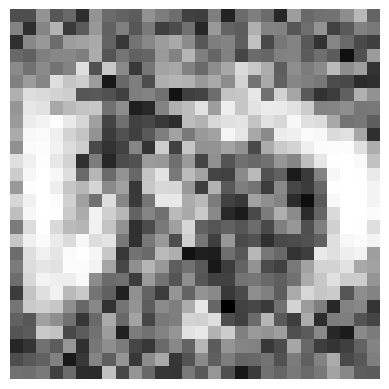

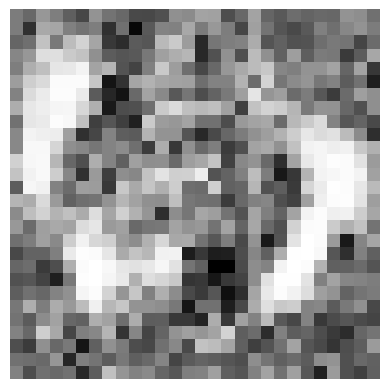

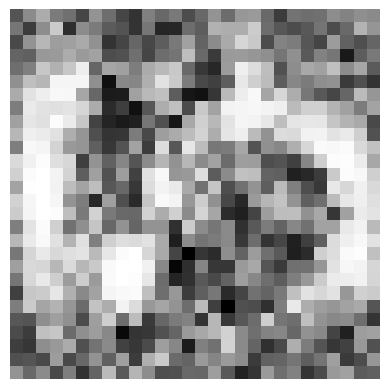

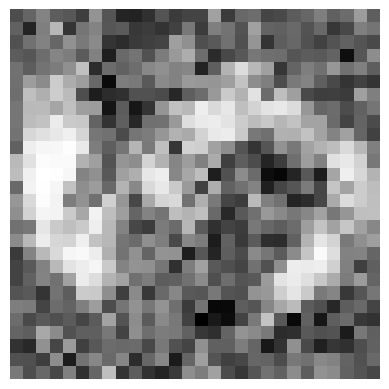

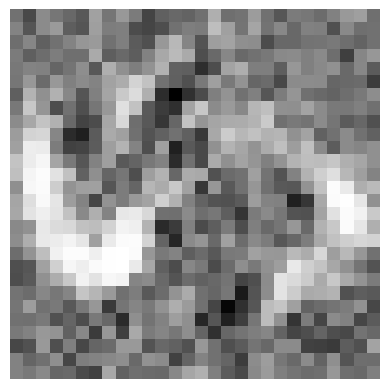

In [165]:
generator = Generator(latent_dim, label_dim, style_dim, img_dim).to(device)

generator.load_state_dict(torch.load(save_generator, map_location=device))
generator.eval()

class_label = 1
style_label = 1

# Create one-hot encoded labels
class_one_hot = torch.eye(num_classes)[class_label].unsqueeze(0).to(device)
style_one_hot = torch.eye(num_styles)[style_label].unsqueeze(0).to(device)

num_images = 5

noise = torch.randn(num_images, latent_dim).to(device)

labels = class_one_hot.repeat(num_images, 1)
styles = style_one_hot.repeat(num_images, 1)

# Generate fake images using the generator
with torch.no_grad():
    fake_images = generator(noise, labels, styles)

# Reshape the generated images for visualization
fake_images = fake_images.view(-1, 1, 28, 28)

for i in range(num_images):
    plt.figure()
    plt.imshow(fake_images[i].cpu().numpy().squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

# Quantitative Comparison

In [154]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

mse_scores = []
ssim_scores = []

with torch.no_grad():
    for data, label, style in test_loader:
        recon_batch, mu, logvar = cvae(data, label, style)
        
        mse = mean_squared_error(data.view(-1, 784).cpu().numpy(), recon_batch.cpu().numpy())
        mse_scores.append(mse)
        
        for i in range(len(data)):
            original_img = data[i].view(28, 28).cpu().numpy()
            reconstructed_img = recon_batch[i].view(28, 28).cpu().numpy()
            ssim_score = ssim(original_img, reconstructed_img, data_range=reconstructed_img.max() - reconstructed_img.min())
            ssim_scores.append(ssim_score)

print(f"Average MSE for C-VAE: {np.mean(mse_scores):.4f}")
print(f"Average SSIM for C-VAE: {np.mean(ssim_scores):.4f}")

Average MSE for C-VAE: 0.0670
Average SSIM for C-VAE: 0.3881


In [156]:
def generate_cgan_images(generator, class_label, style_label, num_images=5):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, latent_dim).to(device)
        class_one_hot = torch.eye(num_classes)[torch.tensor([class_label] * num_images)].to(device)
        style_one_hot = torch.eye(num_styles)[torch.tensor([style_label] * num_images)].to(device)
        generated_images = generator(noise, class_one_hot, style_one_hot)
        return generated_images.view(-1, 1, 28, 28)

fake_images = generate_cgan_images(generator, class_label=1, style_label=1, num_images=100)

real_images_flattened = test_images[:100].view(-1, 784).cpu().numpy()
fake_images_flattened = fake_images.view(-1, 784).cpu().numpy()

mse_cgan = mean_squared_error(real_images_flattened, fake_images_flattened)
print(f"MSE for C-GAN: {mse_cgan:.4f}")

MSE for C-GAN: 0.2839
